# CASA0013 FSDS Assignment 3: Data-Led Executive Briefing

In [1]:
# Import required packages

import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.preprocessing import MinMaxScaler

## Housing Tenure

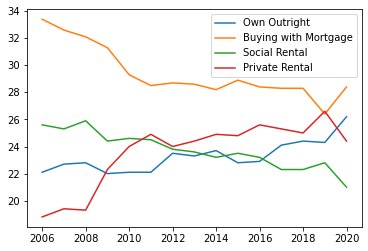

In [113]:
# Read in data
url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/tenure-households-borough.xlsx?raw=true'
tenure = pd.concat(pd.read_excel(url, sheet_name = list(map(str, range(2006, 2021)))))

# Rename and keep only useful columns
tenure_cols = ['Own Outright', 'Buying with Mortgage', 'Social Rental', 'Private Rental']
tenure.rename({'Unnamed: 1': 'Area',
               'Percentages': tenure_cols[0],
               'Unnamed: 15': tenure_cols[1],
               'Unnamed: 16': tenure_cols[2],
               'Unnamed: 17': tenure_cols[3]},
              axis = 1, inplace = True)
tenure = tenure[['Area'] + tenure_cols]

# Keep only data in London
tenure.dropna(subset = ['Area'], axis = 0, inplace = True)
tenure = tenure[tenure['Area'].str.match(r'London')]

# Reset index to 'Year' column and convert data type
tenure.reset_index(level = 0, inplace = True)
tenure.rename({'level_0': 'Year'}, axis = 1, inplace = True)
tenure['Year'] = tenure['Year'].astype('int', copy = False)
tenure[tenure_cols] = tenure[tenure_cols].astype('float', copy = False)

# Plot
plt.plot(tenure['Year'], tenure[tenure_cols])
plt.legend(labels = tenure_cols)

In [114]:
tenure

,Year,Area,Own Outright,Buying with Mortgage,Social Rental,Private Rental
45,2006,London,22.1,33.4,25.6,18.8
45,2007,London,22.7,32.6,25.3,19.4
45,2008,London,22.8,32.1,25.9,19.3
45,2009,London,22.0,31.3,24.4,22.3
45,2010,London,22.1,29.3,24.6,24.0
45,2011,London,22.1,28.5,24.5,24.9
45,2012,London,23.5,28.7,23.8,24.0
45,2013,London,23.3,28.6,23.6,24.4
45,2014,London,23.7,28.2,23.2,24.9
45,2015,London,22.8,28.9,23.5,24.8


## Proxy 1: Proportion of Total Residential Rent Generated from Airbnb

### Airbnb data for 2020

Define functions for scalability
- Read and clean Airbnb data
- Compute estimated occupancy

In [2]:
# Define function to read and clean Airbnb data

def load_airbnb(date_scraped):
    
    '''
    Load and clean Airbnb data

    :param date_scraped: date where Airbnb data is scrapped in yyyymmdd in string format
    :return: cleaned up geopandas dataframe
    '''
    
    # Compose url and print message
    print(f'Loading and cleaning Airbnb data for {date_scraped}')
    url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/listings-' + (
    date_scraped + '.csv.gz?raw=true')
    
    # Define columns to read in
    cols = ['id', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews_ltm']

    # Load data
    df = pd.read_csv(url, usecols=cols, compression='gzip',low_memory=False)
    print(f'{df.shape[0]} listings were loaded.')
    
    # Remove inactive listing - no listing within last 12 months.
    df.drop(df[df['number_of_reviews_ltm'] == 0].index, axis=0, inplace=True)
    print(f'{df.shape[0]} listings were left after removing inactive listings.')
    
    # Keep only entire place listings
    df.drop(df[df['room_type'] != 'Entire home/apt'].index, axis=0, inplace=True)
    print(f'{df.shape[0]} listings were left after keeping only entire home/apt listings.')
    
    # Clean the price data
    df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)
    
    # Convert dataframe into geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='epsg:4326')
    gdf = gdf.to_crs('epsg:27700')
    
    # return cleaned gdf
    return gdf

In [3]:
# Define function to estimate occupancy using the occupancy model, and compute the income from Airbnb

def occupancy_model(df, review_rate = 0.5, average_occupancy = 5.3, occupancy_cap = 0.7):
    
    '''
    Compute the estimated occupancy of each listing in the past yearusing the occupancy model

    :param gdf: dataframe of Airbnb data
    :return: dataframe with occupancy computed
    '''
    # Compute estimated number of bookings
    df['est_bookings'] = df['number_of_reviews_ltm'] / review_rate
    
    # Compute estimated nights of occupancy
    df['est_occupancy'] = df['est_bookings'] * average_occupancy
    df['est_occupancy'] = df['est_occupancy'].apply(np.ceil)
    
    # If listing has higher minimum number of nights, update estimated nights of occupancy
    df['est_occupancy'] = df[['minimum_nights','est_occupancy']].max(axis = 1)
    
    # Cap occupancy rate at 70% of the nights in a year
    df.loc[(df['est_occupancy'] > (occupancy_cap * 365)), ['est_occupancy']] = math.floor(occupancy_cap * 365)
    
    df['airbnb_income'] = df['price'] * df['est_occupancy']
    
    # return dataframe with occupancy computed for each listing
    return df

Read 2020 data

In [4]:
# Load Airbnb data scraped on 16 Dec 2020
date_scraped = '20201216'
airbnb_2020 = load_airbnb(date_scraped)

Loading and cleaning Airbnb data for 20201216
77136 listings were loaded.
26672 listings were left after removing inactive listings.
16031 listings were left after keeping only entire home/apt listings.


/tmp/ipykernel_78/1773992481.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


In [5]:
# Compute estimated occupancy
airbnb_2020 = occupancy_model(airbnb_2020)

### Private rental data for 2020

Number of households in private rental in 2020

In [6]:
# Read in data
url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/tenure-households-borough.xlsx?raw=true'
rental_households = pd.read_excel(url, sheet_name = '2020')

# Rename and keep only useful columns
rental_households.rename({' ': 'Area Code', 'Unnamed: 1': 'Area', 'Unnamed: 5': 'Households'},
                         axis = 1, inplace = True)
rental_households = rental_households[['Area Code', 'Area', 'Households']]

# Keep only data on London boroughs (Area Code starts with E09) and London
rental_households.dropna(axis = 0, inplace = True)
rental_households = (
rental_households[rental_households['Area Code'].str.match(r'E09')|rental_households['Area'].str.match(r'London')])
    
# Replace suppressed data with 0
rental_households = rental_households.replace({'-': 0})

# Estimate number of households in City of London
rental_households.loc[(rental_households.Area == 'City of London'), ['Households']] = (
    rental_households[rental_households.Area == 'London'].Households.values - 
    sum(rental_households[rental_households.Area != 'London'].Households))

# Drop data for London
rental_households.drop(rental_households[rental_households.Area == 'London'].index, inplace = True)

Define function to read in rental rate data for scalability

In [7]:
# Define function to load and clean private rental rate data

def load_rental(year, sheet):
    
    '''
    Load and clean the data on private rental

    :param year: year of data
    :param sheet: sheet name for property type
    :return: cleaned up pandas dataframe
    '''
    
    # Set number of footers to skip
    if sheet == 'Table2.2':
        footer = 36  # 36 for studio
    else:
        footer = 37  # 37 for all other property type
    
    # Read data
    url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/privaterentalmarketstatistics'+ (
        year + '.xls?raw=true')
    df = pd.read_excel(url, sheet_name = sheet, skiprows = 6, skipfooter = footer)
    
    # Drop unused columns
    df.drop(columns = ['Unnamed: 0', 'LA Code1'], inplace = True)
    
    # Keep only data on London boroughs (Area Code starts with E09)
    df = df[df['Area Code1'].str.match(r'E09')].sort_values(by = ['Area Code1'], ascending=True)
    
    # Replace suppressed data with 0
    df = df.replace({'-': 0,
                     '.': 0,
                     '..': 0})
    
    # return cleaned df
    return df.reset_index(drop = True)

Rental rate in 2020

In [8]:
# Year
year = '2020'

# Dictionary for property type and sheet name
prop_sheet = {'studio': 'Table2.2',
              '1br': 'Table2.3',
              '2br': 'Table2.4',
              '3br': 'Table2.5',
              '4br': 'Table2.6'}

# Read data for each property type
for prop, sheet in prop_sheet.items():
    globals()['rental_' + prop] = load_rental(year, sheet)

In [9]:
# Compute average of median rental price, weighted by the count of rents

## Initialize dataframe
rental2020_median = rental_studio[['Area Code1', 'Area']]

## Add two columns - one to track total counts, one to track product of counts and median rental
rental2020_median = rental2020_median.reindex(columns = [*rental2020_median.columns.tolist(),
                                                         'Counts','Median'], fill_value = 0)

## Add counts, and product of counts and median rental, for all property types
for prop in prop_sheet.keys():
    ## Add counts
    rental2020_median.Counts = rental2020_median.Counts + globals()['rental_' + prop]['Count of rents']
    ## Add product of counts and median rental
    rental2020_median.Median = rental2020_median.Median + (
        (globals()['rental_' + prop]['Count of rents'] * globals()['rental_' + prop]['Median']))

## Compute average of median rent
rental2020_median.Median = rental2020_median.Median / rental2020_median.Counts

### London boroughs

In [10]:
# Read boundaries
url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/statistical-gis-boundaries-london.gpkg?raw=true'
boros = gpd.read_file(url)
boros = boros.to_crs('epsg:27700')

# Keep only useful columns
boros = boros[['NAME', 'GSS_CODE', 'geometry']]

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


### Join and map proxy

Compute total income from Airbnb for each borough

In [11]:
# Join Airbnb listings to boroughs
airbnb_2020_boros = gpd.sjoin(airbnb_2020, boros, op = 'within', how = 'left')

# Drop listings with no borough names (outside boroughs)
airbnb_2020_boros.drop(index=airbnb_2020_boros[airbnb_2020_boros.NAME.isnull()].index, axis=1, inplace=True)

# Compute income from Airbnb for each borough
airbnb_income_2020 = airbnb_2020_boros.groupby('NAME').agg({"airbnb_income": np.sum}).reset_index()

# Join back to boros geodataframe
boros = boros.merge(airbnb_income_2020, on = 'NAME')

Compute total private rental income for each borough

In [12]:
boros['rental_income'] = rental_households.Households.values * rental2020_median.Median.values * 12

Compute and map proxy 1

In [13]:
boros['prop_airbnb'] = boros.airbnb_income / (boros.airbnb_income + boros.rental_income) * 100

<AxesSubplot:>

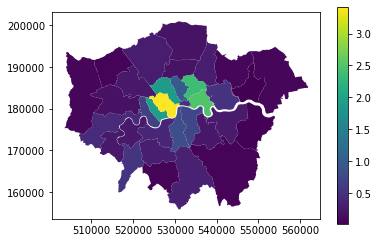

In [14]:
boros.plot(column = 'prop_airbnb', legend = True)

## Proxy 2: Proportion of Private Rent Earned by Airbnb Listings

### Airbnb data for 2021

Read data

In [15]:
# Load Airbnb data scraped on 10 Oct 2021
date_scraped = '20211010'
airbnb_2021 = load_airbnb(date_scraped)

Loading and cleaning Airbnb data for 20211010
67903 listings were loaded.
19238 listings were left after removing inactive listings.
12206 listings were left after keeping only entire home/apt listings.


/tmp/ipykernel_78/1773992481.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


Compute median Airbnb price

In [16]:
# Join Airbnb listings to boroughs
airbnb_2021_boros = gpd.sjoin(airbnb_2021, boros, op = 'within', how = 'left')

# Drop listings with no borough names (outside boroughs)
airbnb_2021_boros.drop(index=airbnb_2021_boros[airbnb_2021_boros.NAME.isnull()].index, axis=1, inplace=True)

# Compute median price for Airbnb for each borough
airbnb_price_2021 = airbnb_2021_boros.groupby('NAME').agg({"price": np.median}).reset_index()

# Join back to boros geodataframe
boros = boros.merge(airbnb_price_2021, on = 'NAME')

### Rental data for 2021

In [17]:
# Year
year = '2021'

# Dictionary for property type and sheet name
prop_sheet = {'studio': 'Table2.2',
              '1br': 'Table2.3',
              '2br': 'Table2.4',
              '3br': 'Table2.5',
              '4br': 'Table2.6'}

# Read data for each property type
for prop, sheet in prop_sheet.items():
    globals()['rental_' + prop] = load_rental(year, sheet)

In [18]:
# Compute average of median rental price, weighted by the count of rents

## Initialize dataframe
rental2021_median = rental_studio[['Area Code1', 'Area']]

## Add two columns - one to track total counts, one to track product of counts and median rental
rental2021_median = rental2021_median.reindex(columns = [*rental2021_median.columns.tolist(),
                                                         'Counts','Median'], fill_value = 0)

## Add counts, and product of counts and median rental, for all property types
for prop in prop_sheet.keys():
    ## Add counts
    rental2021_median.Counts = rental2021_median.Counts + globals()['rental_' + prop]['Count of rents']
    ## Add product of counts and median rental
    rental2021_median.Median = rental2021_median.Median + (
        (globals()['rental_' + prop]['Count of rents'] * globals()['rental_' + prop]['Median']))

## Compute average of median rent
rental2021_median.Median = rental2021_median.Median / rental2021_median.Counts

In [19]:
# Join median rent to boundaries
boros = boros.merge(rental2021_median, left_on = 'GSS_CODE', right_on = 'Area Code1')
boros.drop(columns = ['Area Code1', 'Area','Counts'], inplace = True)

### Compute and map proxy 2

In [20]:
boros['prop_price'] = (boros.price * 365 * 0.7) / (boros.Median * 12) * 100

<AxesSubplot:>

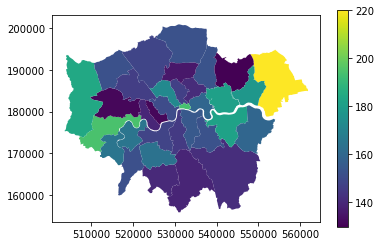

In [21]:
boros.plot(column = 'prop_price', legend = True)

## Clustering

This is a test to see if we can identify clusters using K-Means clustering.

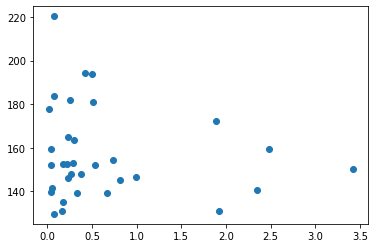

In [52]:
# Extract the two proxies

cluster = boros[['NAME', 'geometry', 'prop_airbnb', 'prop_price']]
plt.scatter(cluster.prop_airbnb, cluster.prop_price)

Based on scatter plot above, it seems like there are some distinct clusters.

In [79]:
cols = ['prop_airbnb', 'prop_price']
scalers = [MinMaxScaler().fit(cluster[x].values.reshape(-1,1)) for x in cols]

data_slice = cluster[cols].copy()

for i in range(0, len(cols)):
    # Ditto this -- can you explain what this code is doing
    data_slice[cols[i]] = scalers[i].transform(data_slice[cols[i]].values.reshape(-1,1))

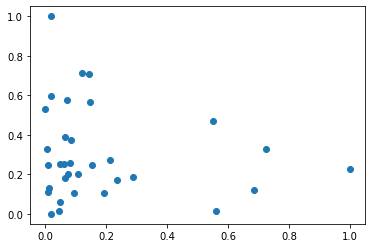

In [83]:
plt.scatter(data_slice.prop_airbnb, data_slice.prop_price)

{'n': [2, 3, 4, 5, 6, 7], 'ss': [0.5580132070328856, 0.5881751525979119, 0.41713977951714776, 0.4091672062642813, 0.3827593363563794, 0.3944488301865358]}


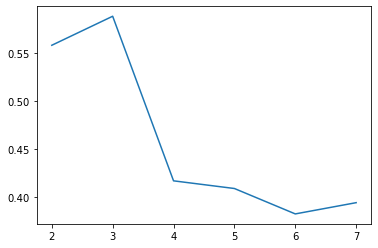

In [82]:
# Trying for different numbers of cluster
results = {'n':[], 'ss':[]}

for num_clusters in range(2,8,1):
    
    # Do KMeans clustering
    kmeans_output = sklc.KMeans(n_clusters=num_clusters, n_init=100).fit(data_slice)
    
    # Calculate silhouette score
    clustering_ids_kmeans = kmeans_output.labels_
    silhouette_kmeans = sklm.silhouette_score(data_slice, clustering_ids_kmeans)
    
    results['n'].append(num_clusters)
    results['ss'].append(silhouette_kmeans)
    
print(results)
plt.plot(results['n'], results['ss'])

In [84]:
# Proceed with clustering with 3 clusters

# This line sets the number of clusters you want to find:
num_clusters = 3

# This line performs the k-means clustering:
kmeans_output = sklc.KMeans(n_clusters=num_clusters, n_init=100, random_state=42).fit(data_slice)

# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# These lines add the cluster IDs to the original data and save the data with these added cluster IDs.
cluster["Cluster"] = clustering_ids_kmeans

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


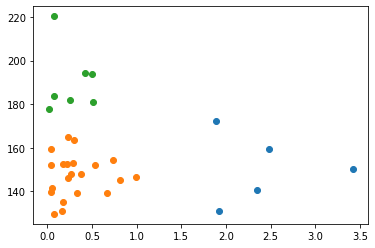

In [85]:
cluster0 = cluster[cluster.Cluster == 0]
cluster1 = cluster[cluster.Cluster == 1]
cluster2 = cluster[cluster.Cluster == 2]

plt.scatter(cluster0.prop_airbnb, cluster0.prop_price)
plt.scatter(cluster1.prop_airbnb, cluster1.prop_price)
plt.scatter(cluster2.prop_airbnb, cluster2.prop_price)

#plt.show()

<AxesSubplot:>

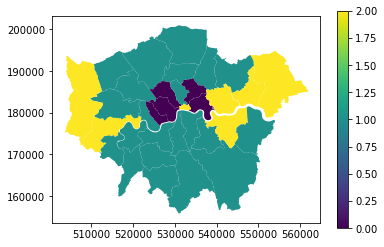

In [87]:
cluster.plot(column = 'Cluster', legend = True)

## To do list
- sort boros
- make the computation of total Airbnb income and median Airbnb price into a function
- make the compuatation of median rental rate into a function
- standardize naming convention in boro gdf
- Investigate Havering